In [1]:
import sys
sys.path.append('..')

from olfactory_navigation import Environment, Agent
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

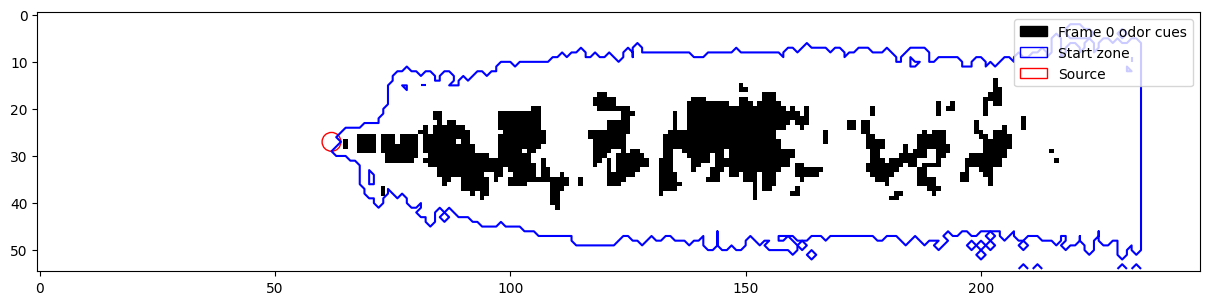

In [5]:
# data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH
data_path = "G:\\My Drive\\Documents\\Universita di Genova\\Pimlb work\\nose_data_27_123.npy"

env = Environment(data_file=data_path,
                  data_source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  multiplier=np.array([2.0,1.4]),
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_threshold=3e-6)

env.plot()

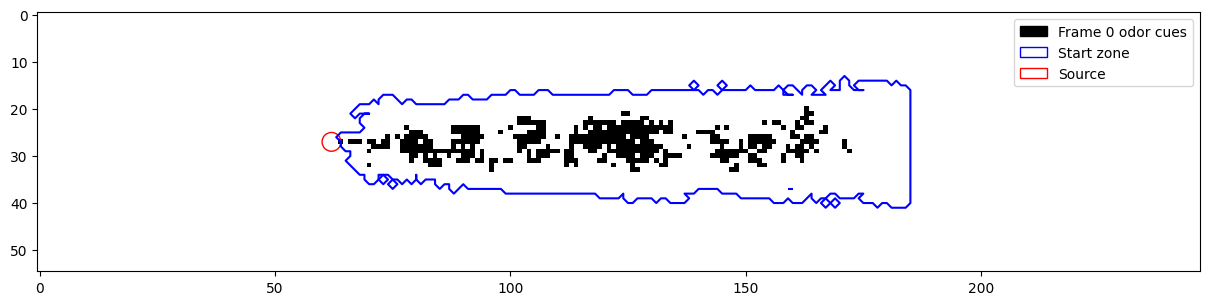

In [3]:
# data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH
data_path = "G:\\My Drive\\Documents\\Universita di Genova\\Pimlb work\\nose_data_27_123.npy"

env = Environment(data_file=data_path,
                  data_source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_threshold=3e-6)

env.plot()

In [10]:
env.margins[:,0]

array([14, 62])

In [7]:
np.sum(env.margins, axis=1)

array([ 28, 124])

In [4]:
env.save(force=True)

Environment saved to: ./Env-55_247-edge_wrap_vertical-start_custom_10_40_50_200-source_27_62_radius2


In [5]:
ag = FSVI_Agent(env)

[05/16/2024, 16:58:16] Instantiation of MDP Model:
[05/16/2024, 16:58:16] - 13585 states
[05/16/2024, 16:58:16] - 4 actions
[05/16/2024, 16:58:16] - At most 1 reachable states per state-action pair
[05/16/2024, 16:58:16] - Starting generation of transitions table
[05/16/2024, 16:58:16]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[05/16/2024, 16:58:16]     > Done in 0.000s
[05/16/2024, 16:58:16] - Generation of state grid
[05/16/2024, 16:58:16] - Generating start probabilities table
[05/16/2024, 16:58:16] - Starting computation of reachable state probabilities from transition data
[05/16/2024, 16:58:16]     > Done in 0.000s

[05/16/2024, 16:58:16] POMDP particular parameters:
[05/16/2024, 16:58:16] - 3 observations
[05/16/2024, 16:58:16] - Starting of transitional observations for reachable states table
[05/16/2024, 16:58:16]     > Done in 0.004s
[05/16/2

In [9]:
_ = ag.train(expansions=300, force=True, use_gpu=True)

[05/16/2024, 14:55:59] MDP_policy, not provided. Solving MDP with Value Iteration...
[05/16/2024, 14:55:59] Sending Model to GPU...
[05/16/2024, 14:55:59]     > Done in 0.237s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 13585-state, 4-action
  - Converged in 918 iterations and 1.3113 seconds
  - Took on average 0.0014s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 13585 state, 4 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 2287 alpha vectors.
  - Converged in 517.4991s

  - Expand function took on average 0.0318s and yielded on average 660.03 beliefs per iteration. (0.0015s/it/belief)
  - Backup function took on average 1.6932s and yielded on average 7.61 alpha vectors per iteration. (0.0031s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


In [7]:
ag.value_function.plot()

[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


In [8]:
# ag.save(force=False, save_environment=False)

In [9]:
hist = run_all_starts_test(ag, use_gpu=True)
# hist = run_test(n=100, agent=ag, time_shift=2400, use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 4.365s:
Simulations reached goal: 2373/2393 (20 failures) (99.16%)
	- Average step count: 95.173 +- 93.98 (Successfull only: 87.547 +- 44.15)
	- Extra steps: 24.140 +- 87.59 (Successful only: 16.201 +- 13.93)
	- Average discounted rewards (ADR): 0.452 +- 0.19 (Successfull only: 0.455 +- 0.19)
	- Tmin/T: 0.817 +- 0.14 (Successful only: 0.824 +- 0.12)


In [ ]:
hist.save()

Simulations saved to: ./Simulations-s_55_247-n_2393-05102024_164939-horizon_1000.csv
Simulation's analysis saved to: ./Simulations-s_55_247-n_2393-05102024_164939-horizon_1000-analysis.csv


In [9]:
loaded_hist = SimulationHistory.load_from_file('./Simulations-s_55_247-n_2393-05102024_164939-horizon_1000.csv', agent=ag)

Environment "55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2" loaded from memory


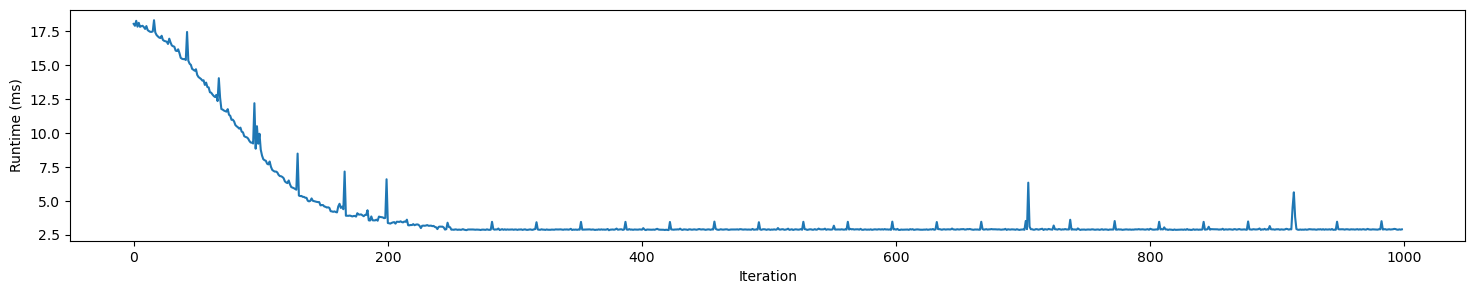

In [10]:
loaded_hist.plot_runtimes()

In [13]:
hist2 = SimulationHistory.load_from_file('./Simulations-s_55_247-n_100-horizon_198-03192024_181337.csv')

Environment "55_247-edge_wrap_vertical-start_odor_present-source_27_62_radius2" loaded from memory


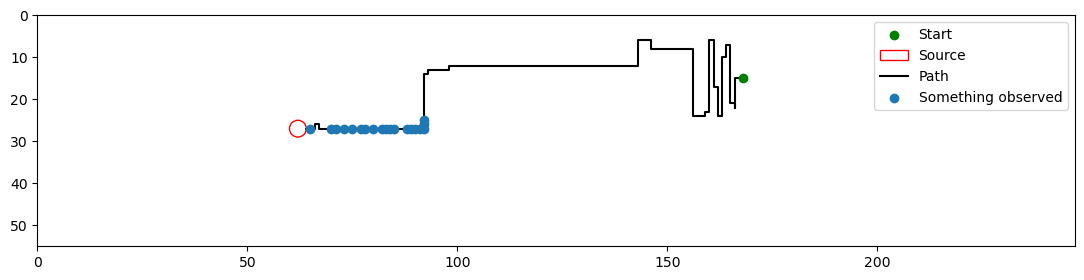

In [15]:
loaded_hist.plot(3)